In [1]:
from folktables import ACSDataSource, ACSEmployment

data_source = ACSDataSource(survey_year='2018', horizon='1-Year', survey='person')
acs_data = data_source.get_data(states=["AL"], download=True)
features, label, group = ACSEmployment.df_to_pandas(acs_data)

In [2]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# scaler = StandardScaler()
scaler = MinMaxScaler()
features[features.columns] = scaler.fit_transform(features[features.columns])
features

,AGEP,SCHL,MAR,RELP,DIS,ESP,CIT,MIG,MIL,ANC,NATIVITY,DEAR,DEYE,DREM,SEX,RAC1P
0,0.204301,0.750000,1.0,1.000000,1.0,0.000,0.0,1.000000,1.0,0.000000,0.0,1.0,1.0,1.0,1.0,0.000
1,0.193548,0.750000,1.0,1.000000,1.0,0.000,0.0,1.000000,1.0,0.000000,0.0,1.0,1.0,1.0,1.0,0.125
2,0.569892,0.708333,1.0,0.941176,0.0,0.000,0.0,0.333333,1.0,0.333333,0.0,1.0,1.0,0.5,0.0,0.000
3,0.301075,0.791667,1.0,0.941176,1.0,0.000,0.0,0.333333,0.5,0.000000,0.0,1.0,1.0,1.0,0.0,0.000
4,0.268817,0.500000,1.0,0.941176,0.0,0.000,0.0,1.000000,1.0,0.000000,0.0,1.0,1.0,0.5,1.0,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47772,0.193548,0.666667,1.0,0.117647,1.0,0.000,0.0,0.333333,1.0,0.000000,0.0,1.0,1.0,1.0,1.0,0.000
47773,0.161290,0.458333,1.0,0.117647,1.0,0.875,0.0,0.333333,0.0,0.000000,0.0,1.0,1.0,1.0,0.0,0.000
47774,0.107527,0.250000,1.0,0.117647,1.0,0.875,0.0,0.333333,0.0,0.000000,0.0,1.0,1.0,1.0,0.0,0.000
47775,0.043011,0.041667,1.0,0.117647,1.0,0.875,0.0,0.333333,0.0,0.000000,0.0,1.0,1.0,0.0,0.0,0.000


In [3]:
X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
    features, label, group, test_size=0.2, random_state=0)

###### Your favorite learning algorithm here #####
model = LogisticRegression()
model.fit(X_train, y_train)
yhat = model.predict(X_test)

/Users/bishwamittraghosh/mambaforge-pypy3/envs/fairness_tutorial/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [4]:
white_tpr = np.mean(yhat[(y_test.values == 1).ravel() & (X_test['SEX'].values == 0)])
black_tpr = np.mean(yhat[(y_test.values == 1).ravel() & (X_test['SEX'].values == 1)])

# Equality of opportunity violation: 0.0871
white_tpr - black_tpr

0.10777651592724302

In [6]:
from fairxplainer.fair_explainer import FairXplainer
from fairxplainer.fair_explainer import plot as fif_plot
from fairxplainer import utils

fairXplainer = FairXplainer(model, X_test, ['SEX'])
fairXplainer.compute(maxorder=2, spline_intervals=3, verbose=True, cpu_time=800)




c Decomposition for  SEX = 1.0
c positive prediction probability of  SEX = 1.0 is 0.3767413688673531
c sample shape: (4953, 16)
c sensitive group: SEX = 1.0
c variance of Y 0.23480730985130607
c mean of Y 0.3767413688673531



c Decomposition for  SEX = 0.0
c positive prediction probability of  SEX = 0.0 is 0.47230067347382143
c sample shape: (4603, 16)
c sensitive group: SEX = 0.0
c variance of Y 0.24923274730999612
c mean of Y 0.47230067347382143


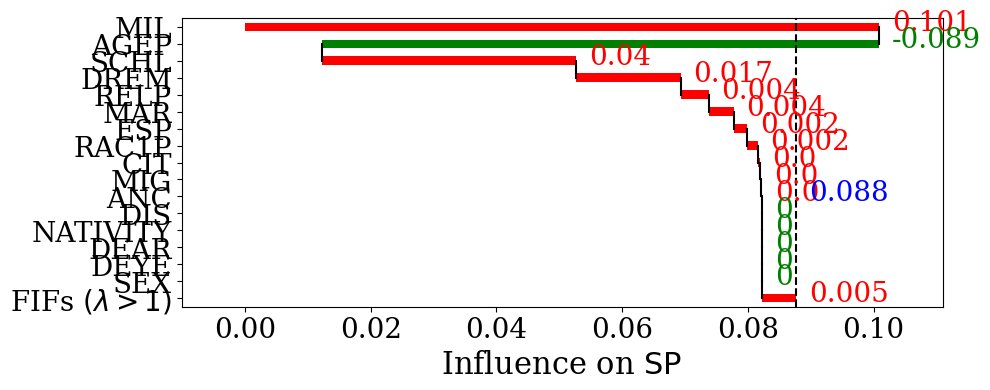

Exact statistical parity 0.09555930460646833


<Figure size 1000x400 with 0 Axes>

In [7]:
result = fairXplainer.get_weights()

fontsize = 22
labelsize = 20

plt = fif_plot(result, 
                draw_waterfall=True, 
                labelsize=labelsize, 
                figure_size=(10,4), 
                text_y_pad=0.2, 
                xlim=None, 
                result_y_location=0.6,
                x_label="Influence on " + r"$ \mathsf{SP} $"
            )
plt.show()
plt.clf()
print("Exact statistical parity", fairXplainer.statistical_parity_sample())

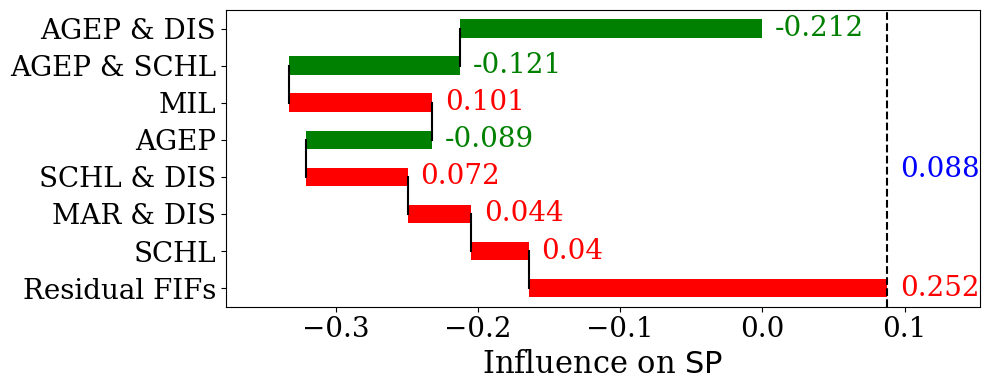

Exact statistical parity 0.09555930460646833


<Figure size 1000x400 with 0 Axes>

In [8]:
k = 7
result = fairXplainer.get_top_k_weights(k=k)

plt = fif_plot(result, 
               draw_waterfall=True, 
               labelsize=labelsize, 
               figure_size=(10,4), 
               text_y_pad=0.2, 
               xlim=None, 
               result_x_pad=0.02,
               x_label="Influence on " + r"$ \mathsf{SP} $"
        )
plt.tight_layout()
plt.show()
plt.clf()

print("Exact statistical parity", fairXplainer.statistical_parity_sample())

In [9]:
from justicia.metrics import Metric
metric = Metric(model=model, 
                data=X_test, 
                sensitive_attributes=['SEX'], 
                verbose=True, 
                encoding="best-correlated",
                dag_threshold=0.2)
metric.compute()
print("Sensitive attributes", metric.given_sensitive_attributes)
print("Disparate Impact:", metric.disparate_impact_ratio)
print("Statistical Parity:", metric.statistical_parity_difference)
print("Time taken", metric.time_taken, "seconds")

/Users/bishwamittraghosh/mambaforge-pypy3/envs/fairness_tutorial/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Learn-dependency encoding is solved based on Learn-efficient-dependency encoding
Expression:  -2 -6 -10 -14 -18 -22 -26 -31 1 5 8 12 15 19 22 26 0 -1 -2 -4 -5 0 -2 -4 -6 -7 -9 -11 -12 10 -1 -5 -8 -12 -15 -19 -22 -26 0 1 2 2 3 0 0 -1 -1 1 5 9 13 17 0 0 0 0 -2 -3 -1 1 5 8 -5 0 0 0 0 0 0 0 0 ?= 26
Translation accuracy 0.9609669317706153
Total number of variables in the formula: 71

---------------------------
Starting DAG learning
Maximum iteration 1  edges: 1 nodes 2
[('65', '64')]
Maximum iteration 5  edges: 5 nodes 9
[('21', '17'), ('31', '48'), ('47', '45'), ('48', '52'), ('65', '64')]
Maximum iteration 10  edges: 10 nodes 14
[('21', '17'), ('31', '48'), ('47', '45'), ('48', '52'), ('48', '1'), ('48', '21'), ('50', '52'), ('54', '53'), ('56', '53'), ('65', '64')]
Maximum iteration 50  edges: 50 nodes 52
[('1', '60'), ('1', '10'), ('2', '1'), ('4', '6'), ('5', '6'), ('7', '6'), ('13', '14'), ('15', '14'), ('16', '14'), ('16', '15'), ('18', '17'), ('19', '17'), ('20', '17'), ('21', '17'